#### Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset,Dataset
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
import glob  
import natsort
from sklearn.metrics import precision_score, recall_score, precision_recall_curve

if torch.cuda.is_available():
    print("CUDA is available. PyTorch is using GPU.")
else:
    print("CUDA is not available. PyTorch is using CPU.")

/home/kirtan/.conda/envs/crossway/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


cuda
CUDA is available. PyTorch is using GPU.


#### Collect & Preprocess Data

In [2]:
seed_constant = 42
torch.manual_seed(seed_constant)
np.random.seed(seed_constant)
random.seed(seed_constant)

In [3]:
path_videos = '/home/kirtan/Documents/FYProject/archive/Videos/Videos/'
path_frames = '/home/kirtan/Documents/FYProject/archive/Videos/Frames/'
# checkpoint_path = "./checkpoints/"

In [4]:
x = np.arange(1, 105)
np.random.shuffle(x)
videos_validation = x[:16]
videos_test = x[16: 16+22]
videos_train = x[16+22:]

In [5]:
print(videos_train, len(videos_train))
print(videos_test, len(videos_test))
print(videos_validation, len(videos_validation))

[ 57  40  36  17  67  35   8  44  69  70  28  20  85  26  74  50  14  25
   4  18  39   9  82   7  68  37  91  84  55  51  71  47 100  62 101  97
  42  59  49  90  58  76  33  98  60  64 102  38  30   2  53  22   3  24
  88  95  75  87  83  21  61  72  15  93  52 103] 66
[ 81  34  13  27  99  56  23  77  45  73  16  43  41  10  86  12 104  79
  29  80   6  63] 22
[31 66 65 54 46 94 92 48 11  1 19 32 89 96 78  5] 16


In [6]:
filenames_train = []
labels_train = []
filenames_validation = []
labels_validation = []
filenames_test = []
labels_test = []

In [7]:
for vid in videos_train:
    folder = path_frames + "video{}/".format(vid)
    frames = glob.glob(folder + 'frame*.jpg')
    frames = natsort.natsorted(frames)
    filenames_train = np.append(filenames_train,frames)
    labels_path = path_frames + "video{}/".format(vid) + "labels{}.npy".format(vid)
    labels_array = np.load(labels_path)
    labels_list = list(labels_array)
    labels_train = np.append(labels_train,labels_list)

filenames_train = np.array(filenames_train)
labels_validation = np.array(labels_validation)

for vid in videos_test:
    folder = path_frames + "video{}/".format(vid)
    frames = glob.glob(folder + 'frame*.jpg')
    frames = natsort.natsorted(frames)
    filenames_test = np.append(filenames_test,frames)
    labels_path = path_frames + "video{}/".format(vid) + "labels{}.npy".format(vid)
    labels_array = np.load(labels_path)
    labels_list = list(labels_array)
    labels_list = np.asarray(labels_list).astype('float32').reshape((-1,1))
    labels_test = np.append(labels_test,labels_list)
    
filenames_test = np.array(filenames_test)
labels_validation = np.array(labels_validation)

for vid in videos_validation:
    folder = path_frames + "video{}/".format(vid)
    frames = glob.glob(folder + 'frame*.jpg')
    frames = natsort.natsorted(frames)
    filenames_validation = np.append(filenames_validation,frames)
#     filenames_validation.append(frames)
    labels_path = path_frames + "video{}/".format(vid) + "labels{}.npy".format(vid)
    labels_array = np.load(labels_path)
    labels_list = list(labels_array)
    labels_list = np.asarray(labels_list).astype('float32').reshape((-1,1))
    labels_validation = np.append(labels_validation,labels_list)

filenames_validation = np.array(filenames_validation)
labels_validation = np.array(labels_validation)

In [8]:
print(labels_validation.shape)
print(labels_validation)
print(type(filenames_train), filenames_validation.shape, filenames_test.shape)
print(type(labels_train), labels_validation.shape, labels_test.shape)


(4200,)
[0. 0. 0. ... 0. 0. 0.]
<class 'numpy.ndarray'> (4200,) (5430,)
<class 'numpy.ndarray'> (4200,) (5430,)


In [9]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels,transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path)

        # Apply transformations
        if self.transform is not None:
            image = self.transform(image)
        label = torch.tensor(label,dtype=torch.int64)
        # print('len(image_path),len(label)',image_path.size(),label.size())
        return {"pixel_value": image, "label": label}

In [10]:
image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.15, contrast=(0.8, 1.5), saturation=(0.6, 3))
    ], p=0.5)
])
transform_aug = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # transforms.RandomResizedCrop(size=(8, 8), scale=(0.8, 1.0)),
    transforms.ToTensor(),
])


In [11]:
train_dataset = CustomDataset(filenames_train, labels_train, transform=image_transform)
train_dataset_aug = CustomDataset(filenames_train, labels_train, transform=transform_aug)
print(type(train_dataset_aug[0]['pixel_value']))
print(type(train_dataset_aug[0]['label']))
print(train_dataset_aug[0]['pixel_value'])
test_dataset = CustomDataset(filenames_test, labels_test, transform=image_transform)
val_dataset = CustomDataset(filenames_validation, labels_validation, transform=image_transform)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
tensor([[[0.0706, 0.0706, 0.0706,  ..., 0.6118, 0.5608, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.5216, 0.4471, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.4275, 0.4235, 0.0706],
         ...,
         [0.0706, 0.0745, 0.0745,  ..., 0.2745, 0.2549, 0.2784],
         [0.0706, 0.0706, 0.0706,  ..., 0.1686, 0.1608, 0.1490],
         [0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706]],

        [[0.0706, 0.0706, 0.0706,  ..., 0.7725, 0.7216, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.6667, 0.5804, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.5373, 0.5333, 0.0706],
         ...,
         [0.0706, 0.0745, 0.0745,  ..., 0.2353, 0.2196, 0.2353],
         [0.0706, 0.0706, 0.0706,  ..., 0.1686, 0.1647, 0.1529],
         [0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706]],

        [[0.0706, 0.0706, 0.0706,  ..., 0.8039, 0.7529, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.6784, 0.6118, 0.0706],
         [0.

/tmp/ipykernel_6085/1707042774.py:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label,dtype=torch.int64)


In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
train_dataloader_aug = DataLoader(train_dataset_aug, batch_size=64, shuffle=True)
batch = next(iter(train_dataloader_aug))
print(batch)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

/tmp/ipykernel_6085/1707042774.py:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label,dtype=torch.int64)


{'pixel_value': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000,

#### Define model

In [13]:
# print(labels)
from transformers import AutoModelForImageClassification
model = AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224",
                                                        num_labels=2,
                                                        ignore_mismatched_sizes=True)
model.to(device) ##moving model to gpu

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ConvNextForImageClassification(
  (convnext): ConvNextModel(
    (embeddings): ConvNextEmbeddings(
      (patch_embeddings): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (layernorm): ConvNextLayerNorm()
    )
    (encoder): ConvNextEncoder(
      (stages): ModuleList(
        (0): ConvNextStage(
          (downsampling_layer): Identity()
          (layers): Sequential(
            (0): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              (pwconv1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELUActivation()
              (pwconv2): Linear(in_features=384, out_features=96, bias=True)
              (drop_path): Identity()
            )
            (1): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              

#### Training 

In [16]:
#check if data is prepared properly
# for images, labels in train_loader:
#     for i in range(len(images)):
#         print("Image shape:", images[i])
#         print("Label:", labels[i])
       
#     break 
##CONTAIS IMAGE PIXEL_VALUES AND LABEL
##Nice work done 

from tqdm.notebook import tqdm 
# Class imbalance handling
# class_weights = torch.tensor([1 / count_0, 1 / count_1, ...])  # Calculate class weights based on class frequencies
# class_weights = class_weights.to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights)

# L2 regularization
l2_lambda = 0.01  # L2 regularization strength
best_val_loss = float('inf')
best_model_state_dict = None
optimizer = torch.optim.AdamW(model.parameters(),lr=5e-5)
# Regularization
def add_regularization(model, lambda_reg):
    l2_reg = torch.tensor(0.).to(device)
    for param in model.parameters():
        l2_reg += torch.norm(param, p=2)  # L2 norm
    return l2_lambda * l2_reg


model = model.to(device)
model.train()

for epoch in range(100):
    print("Epoch:", epoch)
    correct = 0
    total = 0
    running_loss = 0.0
    aug_correct = 0
    aug_total = 0
    aug_running_loss = 0.0

    
    # Training loop
    for idx, batch in enumerate(tqdm(train_dataloader)):
        # Move batch to GPU
        batch = {k: v.to(device) for k, v in batch.items()}
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(pixel_values=batch["pixel_value"], labels=batch["label"])
        loss, logits = outputs.loss, outputs.logits
        loss += add_regularization(model, l2_lambda)  # Apply L2 regularization
        loss.backward()
        optimizer.step()

        # Metrics
        total += batch["label"].shape[0]
        predicted = logits.argmax(-1)
        correct += (predicted == batch["label"]).sum().item()
        running_loss += loss.item()

        accuracy = correct / total
        avg_loss = running_loss / (idx + 1)

        if idx % 100 == 0:
            print(f"Loss after {idx} steps:", avg_loss)
            print(f"Accuracy after {idx} steps:", accuracy)
    
     # Training loop with augmented data
    for idx, batch in enumerate(tqdm(train_dataloader_aug)):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        optimizer.zero_grad()
        
        outputs = model(pixel_values=batch["pixel_value"], labels=batch["label"])
        loss, logits = outputs.loss, outputs.logits
        loss += add_regularization(model, l2_lambda)  # Apply L2 regularization
        loss.backward()
        optimizer.step()

        aug_total += batch["label"].shape[0]
        predicted = logits.argmax(-1)
        aug_correct += (predicted == batch["label"]).sum().item()
        aug_running_loss += loss.item()

        accuracy = correct / total
        avg_loss = running_loss / (idx + 1)

        if idx % 100 == 0:
            print(f"Loss after {idx} steps (Augmented Data):", avg_loss)
            print(f"Accuracy after {idx} steps (Augmented Data):", accuracy)


    # Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0
    val_predictions = []
    val_labels = []
    
    with torch.no_grad():
        for val_batch in tqdm(val_dataloader):
            val_batch = {k: v.to(device) for k, v in val_batch.items()}
            
            val_outputs = model(pixel_values=val_batch["pixel_value"], labels=val_batch["label"])
            val_loss, val_logits = val_outputs.loss, val_outputs.logits
            val_loss += add_regularization(model, l2_lambda)  # Apply L2 regularization
            val_total += val_batch["label"].shape[0]
            val_predicted = val_logits.argmax(-1)
            val_correct += (val_predicted == val_batch["label"]).sum().item()
            val_running_loss += val_loss.item()

            val_predictions.extend(val_predicted.cpu().numpy())
            val_labels.extend(val_batch["label"].cpu().numpy())

    val_accuracy = val_correct / val_total
    val_avg_loss = val_running_loss / len(val_dataloader)

    print("Validation Loss:", val_avg_loss)
    print("Validation Accuracy:", val_accuracy)
    
    if val_avg_loss < best_val_loss:
        best_val_loss = val_avg_loss
        best_model_state_dict = model.state_dict()
        torch.save(best_model_state_dict, "best_model.pt")

    # Calculate precision, recall, and precision at recall
    precision = precision_score(val_labels, val_predictions)
    recall = recall_score(val_labels, val_predictions)
    precision_at_recall = precision_recall_curve(val_labels, val_predictions, pos_label=1)

    print("Precision:", precision)
    print("Recall:", recall)
    print("Precision at Recall:", precision_at_recall)

    model.train()



Epoch: 0


  0%|          | 0/264 [00:00<?, ?it/s]

/tmp/ipykernel_6085/1707042774.py:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label,dtype=torch.int64)


Loss after 0 steps: 49.80531311035156
Accuracy after 0 steps: 0.96875
Loss after 100 steps: 49.51870610454295
Accuracy after 100 steps: 0.963490099009901
Loss after 200 steps: 49.26597249804445
Accuracy after 200 steps: 0.9682058457711443


  0%|          | 0/264 [00:00<?, ?it/s]

Loss after 0 steps (Augmented Data): 12965.04343032837
Accuracy after 0 steps (Augmented Data): 0.9708111308466548
Loss after 100 steps (Augmented Data): 128.36676663691455
Accuracy after 100 steps (Augmented Data): 0.9708111308466548
Loss after 200 steps (Augmented Data): 64.50270363347447
Accuracy after 200 steps (Augmented Data): 0.9708111308466548


  0%|          | 0/66 [00:00<?, ?it/s]

Validation Loss: 47.69533087990501
Validation Accuracy: 0.8519047619047619
Precision: 0.8198458574181118
Recall: 0.661741835147745
Precision at Recall: (array([0.30619048, 0.81984586, 1.        ]), array([1.        , 0.66174184, 0.        ]), array([0, 1]))
Epoch: 1


  0%|          | 0/264 [00:00<?, ?it/s]

/tmp/ipykernel_6085/1707042774.py:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label,dtype=torch.int64)


Loss after 0 steps: 47.356204986572266
Accuracy after 0 steps: 0.984375
Loss after 100 steps: 47.16651304641572
Accuracy after 100 steps: 0.9820544554455446


#### Evaluation

In [ ]:
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score

model.eval()

total = 0
correct = 0
true_labels = []
predicted_labels = []

# Evaluation loop with tqdm progress bar
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc='Evaluation Progress'):
        # Move batch to GPU
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(pixel_values=batch["pixel_value"], labels=batch["label"])
        logits = outputs.logits

        # Calculate predictions and accuracy
        predicted = logits.argmax(dim=1)
        total += batch["label"].size(0)
        correct += (predicted == batch["label"]).sum().item()

        # Accumulate true and predicted labels
        true_labels.extend(batch["label"].cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = correct / total

# Calculate precision and recall
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)

# Print evaluation metrics
print("Accuracy on the test set:", accuracy)
print("Precision on the test set:", precision)
print("Recall on the test set:", recall)



In [ ]:
from sklearn.metrics import  f1_score
f1_score_ = f1_score(true_labels,predicted_labels)
print(f1_score_)

0.8618181818181818


#### Inference

/home/kirtan/.conda/envs/crossway/lib/python3.9/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


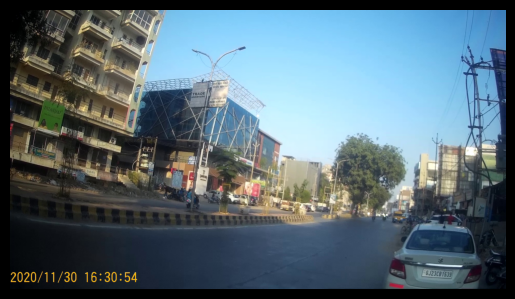

1
None


In [ ]:
import torch
from torchvision import transforms
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
from PIL import Image
feature_extractor = AutoFeatureExtractor.from_pretrained("nielsr/convnext-tiny-finetuned-eurosat")
import matplotlib.pyplot as plt
#to find out all True predicted images             
# main_folder = "/home/kirtan/Documents/FYProject/archive/Videos/Frames/"
# for subfolder in os.listdir(main_folder):
#     subfolder_path = os.path.join(main_folder, subfolder)
#     if os.path.isdir(subfolder_path):
#         for filename in os.listdir(subfolder_path):
#             if filename.endswith(".jpg"):
#                 file_path = os.path.join(subfolder_path, filename)
#                 image = Image.open(file_path).convert("RGB")
#                 pixel_values = feature_extractor(image.convert("RGB"), return_tensors="pt").pixel_values
#                 # print(pixel_values.shape)
#                 pixel_values = pixel_values.to(device)
                # with torch.no_grad():
                #     model = model.to(device)
                #     outputs = model(pixel_values)
                #     logits = outputs.logits
#                     # print(logits.argmax(-1).item())
#                     if(logits.argmax(-1).item() == 1):
#                         print(file_path)

image_path = "/home/kirtan/Documents/FYProject/archive/Videos/Frames/video99/frame129.jpg"
image = Image.open(image_path)

transform = transforms.ToTensor()
image_tensor = transform(image)

# Convert the tensor back to a NumPy array
image_array = image_tensor.numpy()

# Transpose the array to match the shape (H, W, C) expected by Matplotlib
image_array = image_array.transpose(1, 2, 0)

# Plot the image
plt.imshow(image_array)
plt.axis('off')
plt.show()
def get_class(image_path,model):
    image = Image.open(image_path).convert("RGB")
    pixel_values = feature_extractor(image.convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    with torch.no_grad():
        model = model.to(device)
        outputs = model(pixel_values)
        logits = outputs.logits
        print(logits.argmax(-1).item())
print(get_class(image_path,model))

#### Pipleline Api

In [ ]:
from transformers import pipeline
from torchvision.transforms import functional as F
pipe = pipeline("image-classification",
                model=model,
                feature_extractor=feature_extractor,device='cpu')
results = pipe(image_path)

# Print the predicted label and score
print(results)
predicted_label = results[0]['label']
score = results[0]['score']
print(f"Predicted label: {predicted_label}")
print(f"Score: {score}")

[{'score': 0.5167772769927979, 'label': 'LABEL_1'}, {'score': 0.48322275280952454, 'label': 'LABEL_0'}]
Predicted label: LABEL_1
Score: 0.5167772769927979
